# TASK 1
# AI Tool to Read and Analyze Legal Contracts Automatically – EDA & Cleaning
 
This notebook performs:

1. **Exploratory Data Analysis (EDA)** on contract texts  
2. **Text cleaning & normalization** (formatting only, meaning preserved)  
3. Saves cleaned files into `Data/Transformed` as `contract_id_cleaned.txt` for the next steps in the pipeline.


In [45]:
%pip install matplotlib
%pip install wordcloud
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pandas-2.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.3-cp311-cp311-macosx_11_0_arm64.whl (10.8 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.3-py2.py3-none-any.whl (348 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]
Note: you may need to restart the kernel to use updated packages.


In [46]:
## 0. Setup – Imports & Paths
import os
import re
import string
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud

plt.style.use("default")
pd.set_option("display.max_colwidth", 200)

# Paths based on ClauseAI repo structure
CONTRACTS_DIR = "../Data/Raw/full_contract_txt"   # folder that contains all contract .txt files
OUTPUT_DIR = "../Data/Transformed"                # where cleaned .txt files will be saved

os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Contracts directory:", CONTRACTS_DIR)
print("Output directory   :", OUTPUT_DIR)

Contracts directory: ../Data/Raw/full_contract_txt
Output directory   : ../Data/Transformed


## 1. Load Contracts

We load all contracts from `Data/Raw/full_contract_txt`:

- Assume each contract is a `.txt` file.  
- Create a DataFrame with:
  - `contract_id` – file name without extension  
  - `file_name`   – original file name  
  - `file_path`   – full path  
  - `file_size_bytes` – file size on disk  
  - `text` – full text content

In [50]:
contracts_data = []

for fname in os.listdir(CONTRACTS_DIR):
    fpath = os.path.join(CONTRACTS_DIR, fname)

    # skip if not a file or not txt
    if not os.path.isfile(fpath):
        continue
    if not fname.lower().endswith(".txt"):
        continue

    contract_id = os.path.splitext(fname)[0]

    try:
        with open(fpath, "r", encoding="utf-8", errors="ignore") as f:
            text = f.read()
    except Exception as e:
        print(f"Error reading {fpath}: {e}")
        text = ""

    contracts_data.append({
        "contract_id": contract_id,
        "file_name": fname,
        "file_path": fpath,
        "file_size_bytes": os.path.getsize(fpath),
        "text": text
    })

df = pd.DataFrame(contracts_data)
print(f"Loaded {len(df)} contracts.")
df.head()

Loaded 510 contracts.


,contract_id,file_name,file_path,file_size_bytes,text
0,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT.txt,../Data/Raw/full_contract_txt/LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT.txt,54290,"EXHIBIT 10.6\n\n DISTRIBUTOR AGREEMENT\n\n THIS DISTRIBUTOR AGREEMENT (the ""Agreement"") is made by and between Electric City Corp., a Delaware corporatio..."
1,"WHITESMOKE,INC_11_08_2011-EX-10.26-PROMOTION AND DISTRIBUTION AGREEMENT","WHITESMOKE,INC_11_08_2011-EX-10.26-PROMOTION AND DISTRIBUTION AGREEMENT.txt","../Data/Raw/full_contract_txt/WHITESMOKE,INC_11_08_2011-EX-10.26-PROMOTION AND DISTRIBUTION AGREEMENT.txt",70383,"Exhibit 10.26 CONFIDENTIAL TREATMENT HAS BEEN REQUESTED AS TO CERTAIN PORTIONS OF THIS DOCUMENT. EACH SUCH PORTION, WHICH HAS BEEN OMITTED HEREIN AND REPLACED WITH AN ASTERISK [*], HAS BEEN FI..."
2,LohaCompanyltd_20191209_F-1_EX-10.16_11917878_EX-10.16_Supply Agreement,LohaCompanyltd_20191209_F-1_EX-10.16_11917878_EX-10.16_Supply Agreement.txt,../Data/Raw/full_contract_txt/LohaCompanyltd_20191209_F-1_EX-10.16_11917878_EX-10.16_Supply Agreement.txt,11475,"Exhibit 10.16 SUPPLY CONTRACT Contract No: Date: The buyer/End-User: Shenzhen LOHAS Supply Chain Management Co., Ltd. ADD: Tel No. : Fax No. : The seller: ADD: The Contract is concluded and signed..."
3,CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WEB SITE HOSTING AGREEMENT,CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WEB SITE HOSTING AGREEMENT.txt,../Data/Raw/full_contract_txt/CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WEB SITE HOSTING AGREEMENT.txt,15176,"1 Exhibit 10.3\n\nI-on. (LOGO) www.i-on.com 561.394.9484 o 561.394-9773 fax 1733 avenida del sol, boca raton, florida, 33432\n\n..."
4,NELNETINC_04_08_2020-EX-1-JOINT FILING AGREEMENT,NELNETINC_04_08_2020-EX-1-JOINT FILING AGREEMENT.txt,../Data/Raw/full_contract_txt/NELNETINC_04_08_2020-EX-1-JOINT FILING AGREEMENT.txt,1081,Exhibit 1\n\nJOINT FILING AGREEMENT\n\nThe undersigned hereby agree to jointly prepare and file with the applicable regulatory authorities this Schedule 13G or Schedule 13D and any future amendmen...


## 2. Understand Distribution of Contract Sizes & Lengths

We compute for each contract:

- `char_count` – number of characters  
- `word_count` – number of whitespace-separated tokens  
- `num_lines`  – number of lines

This will be used later for histograms, boxplots, and anomaly checks.

In [51]:
def count_words(text: str) -> int:
    if not isinstance(text, str) or not text.strip():
        return 0
    return len(text.split())

def count_lines(text: str) -> int:
    if not isinstance(text, str):
        return 0
    return text.count("\n") + 1

df["char_count"] = df["text"].fillna("").apply(len)
df["word_count"] = df["text"].fillna("").apply(count_words)
df["num_lines"] = df["text"].fillna("").apply(count_lines)

df[["file_size_bytes", "char_count", "word_count", "num_lines"]].describe()

,file_size_bytes,char_count,word_count,num_lines
count,510.000000,510.000000,510.000000,510.000000
mean,52589.152941,52563.005882,7861.188235,383.321569
std,55978.617093,55946.484865,8367.292546,560.199823
min,645.000000,645.000000,109.000000,1.000000
25%,16419.250000,16416.250000,2457.000000,95.500000
50%,33150.500000,33143.000000,5006.000000,204.000000
75%,66397.500000,66394.750000,10196.250000,464.000000
max,338211.000000,338211.000000,47733.000000,6298.000000


## 3. Visualize – Histogram of Contract Length (Word Count)

Task: **Histogram – contract length**  
We plot the distribution of `word_count` across contracts.

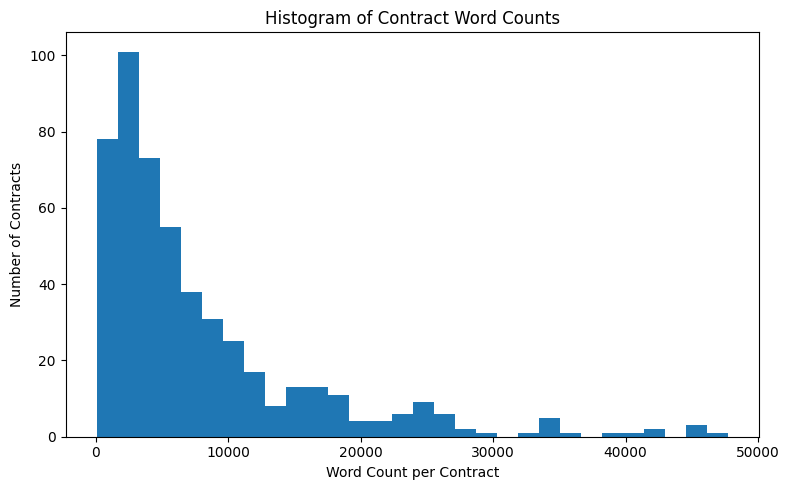

In [52]:
plt.figure(figsize=(8, 5))
plt.hist(df["word_count"], bins=30)
plt.xlabel("Word Count per Contract")
plt.ylabel("Number of Contracts")
plt.title("Histogram of Contract Word Counts")
plt.tight_layout()
plt.show()

## 4. Visualize – Boxplot of Text Length Distribution

Task: **Boxplot – text length distribution**  

We create boxplots for:

- `word_count`  
- `char_count`

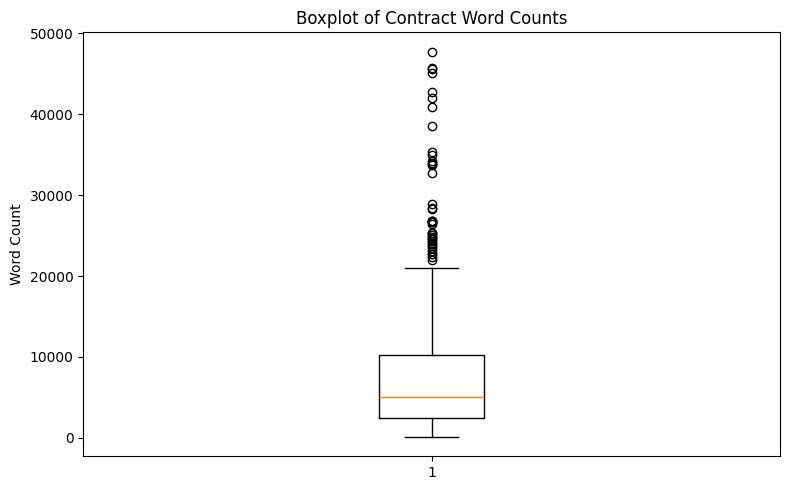

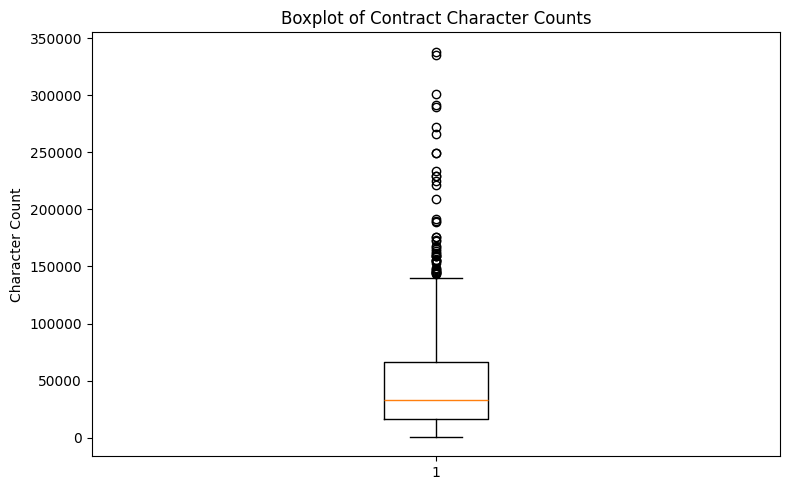

In [53]:
plt.figure(figsize=(8, 5))
plt.boxplot(df["word_count"], vert=True)
plt.ylabel("Word Count")
plt.title("Boxplot of Contract Word Counts")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.boxplot(df["char_count"], vert=True)
plt.ylabel("Character Count")
plt.title("Boxplot of Contract Character Counts")
plt.tight_layout()
plt.show()

## 5. Detect Missing or Empty Files

Task: **Detect missing or empty files**  

We flag contracts that:

- Have empty or whitespace-only text  
- Have zero file size  
- Have very low `word_count` (e.g., `< 10` words)

In [54]:
df["is_empty_text"] = df["text"].fillna("").apply(lambda t: len(t.strip()) == 0)
df["is_zero_size"] = df["file_size_bytes"] == 0
df["is_too_short"] = df["word_count"] < 10

empty_or_missing = df[df["is_empty_text"] | df["is_zero_size"] | df["is_too_short"]]
print(f"Potentially problematic contracts: {len(empty_or_missing)}")
empty_or_missing[["contract_id", "file_name", "file_size_bytes", "word_count",
                  "is_empty_text", "is_zero_size", "is_too_short"]]

Potentially problematic contracts: 0


,contract_id,file_name,file_size_bytes,word_count,is_empty_text,is_zero_size,is_too_short


## 6. Find Most Frequent Legal Terms

Tasks:  

- **Count words per contract** (already done via `word_count`)  
- **Find most frequent legal terms**  

Approach:

1. Lowercase for analysis.  
2. Remove punctuation.  
3. Remove standard English stopwords.  
4. Count frequencies of remaining words.  

In [55]:
basic_stopwords = set("""
a an the is are am was were be being been
of for to in on at by with from as that this it its
and or if then else but not no nor such shall
may might can could would should will do does did
""".split())

punct_table = str.maketrans("", "", string.punctuation)

def tokenize_for_freq(text: str):
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = text.translate(punct_table)
    tokens = text.split()
    tokens = [t for t in tokens if t not in basic_stopwords and len(t) > 2]
    return tokens

all_tokens = []
for t in df["text"]:
    all_tokens.extend(tokenize_for_freq(t))

token_counts = Counter(all_tokens)
most_common_terms = token_counts.most_common(50)
most_common_terms[:20]

[('any', 62236),
 ('agreement', 43576),
 ('party', 30450),
 ('other', 26307),
 ('all', 21937),
 ('under', 14165),
 ('parties', 13510),
 ('section', 13289),
 ('which', 13197),
 ('each', 11481),
 ('company', 11229),
 ('have', 11215),
 ('information', 10921),
 ('product', 10493),
 ('date', 10105),
 ('including', 9917),
 ('has', 9286),
 ('time', 9014),
 ('use', 8759),
 ('products', 8434)]

## 7. Visualize – Wordcloud of Common Clause Keywords

Task: **Wordcloud – common clause keywords**  

We generate a wordcloud for the most frequent terms across all contracts.

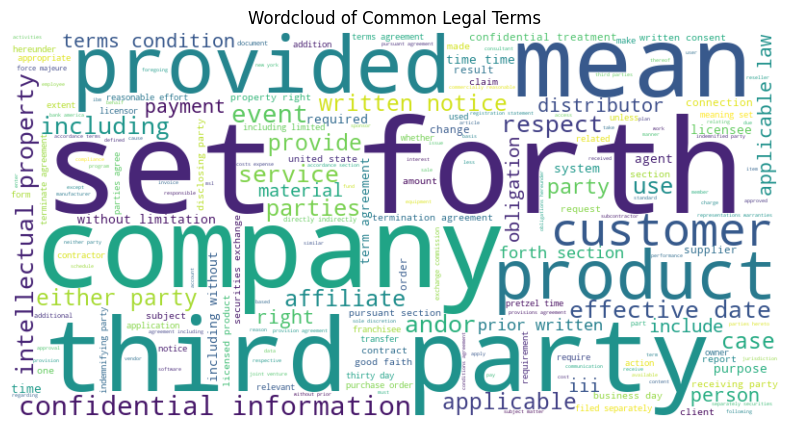

In [57]:
joined_text = " ".join(all_tokens)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(joined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of Common Legal Terms")
plt.show()

## 8. Visualize – Bar Chart of Top N Keywords

Task: **Bar chart – top N keywords (e.g., 20)**  

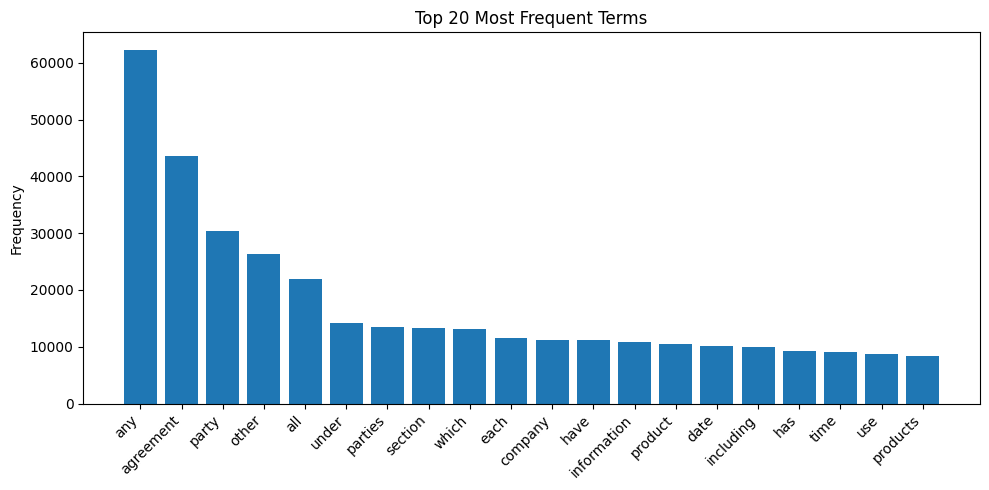

In [58]:
TOP_N = 20
top_terms = most_common_terms[:TOP_N]
terms, counts = zip(*top_terms)

plt.figure(figsize=(10, 5))
plt.bar(range(len(terms)), counts)
plt.xticks(range(len(terms)), terms, rotation=45, ha="right")
plt.ylabel("Frequency")
plt.title(f"Top {TOP_N} Most Frequent Terms")
plt.tight_layout()
plt.show()

## 9. Visualize – Scatter Plot of File Size vs Word Count

Task: **Scatter – file size vs word count**  

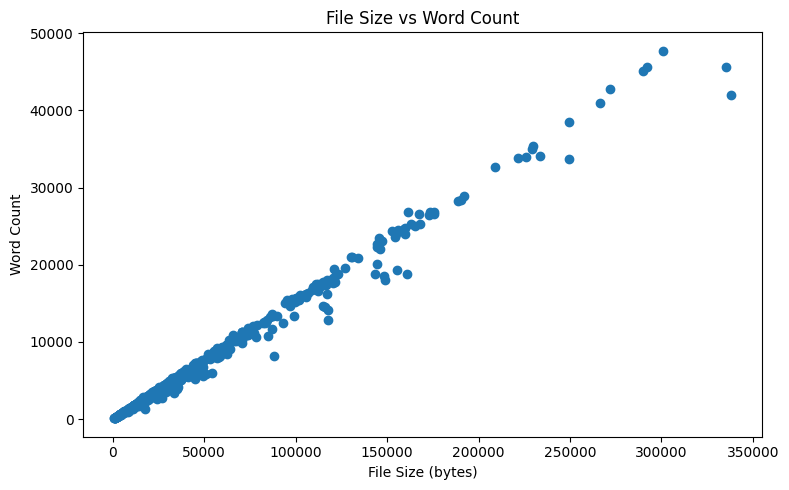

In [59]:
plt.figure(figsize=(8, 5))
plt.scatter(df["file_size_bytes"], df["word_count"])
plt.xlabel("File Size (bytes)")
plt.ylabel("Word Count")
plt.title("File Size vs Word Count")
plt.tight_layout()
plt.show()

## 10. Text Cleaning & Normalization Before Chunking

Tasks covered here:

5. Remove page headers/footers  
6. Normalize whitespace  
7. Remove repeated line breaks  
8. Remove noisy characters (tabs, non-ascii symbols, bullets, etc.)  
9. Fix hyphenation across lines – `(termi\n nation) → termination`  
10. Standardize casing (but keep original headers where useful)  
11. Keep section structure (headers like `TERMINATION`, `CONFIDENTIALITY`)  

## 10.1 Normalize Whitespace & Remove Noise

In [60]:
multi_space_pattern = re.compile(r"[ ]{2,}")
multi_blank_lines_pattern = re.compile(r"\n{3,}")   # 3+ newlines
non_ascii_pattern = re.compile(r"[^\x00-\x7F]+")

bullet_chars = ["•", "●", "◦", "▪", "", "·"]

def normalize_whitespace_and_noise(text: str) -> str:
    if not isinstance(text, str):
        return ""

    text = text.replace("\r\n", "\n").replace("\r", "\n")
    text = text.replace("\t", " ")

    for b in bullet_chars:
        text = text.replace(b, "")

    text = non_ascii_pattern.sub(" ", text)
    text = multi_space_pattern.sub(" ", text)

    lines = [line.rstrip() for line in text.split("\n")]
    text = "\n".join(lines)

    text = multi_blank_lines_pattern.sub("\n\n", text)

    return text

## 10.2 Fix Hyphenation Across Lines

In [61]:
hyphen_line_pattern = re.compile(r"(\w+)-\n(\w+)")

def fix_hyphenation(text: str) -> str:
    if not isinstance(text, str):
        return ""
    while True:
        new_text, count = hyphen_line_pattern.subn(r"\1\2\n", text)
        if count == 0:
            break
        text = new_text
    return text

## 10.3 Remove Page Headers / Footers (Simple Heuristics)

In [62]:
page_line_pattern = re.compile(r"^\s*page\s+\d+\s+of\s+\d+", re.IGNORECASE)
page_number_only_pattern = re.compile(r"^\s*\d+\s*$")

def remove_headers_footers(text: str) -> str:
    if not isinstance(text, str):
        return ""

    lines = text.split("\n")
    cleaned_lines = []

    for line in lines:
        if page_line_pattern.match(line):
            continue
        if page_number_only_pattern.match(line):
            continue
        cleaned_lines.append(line)

    return "\n".join(cleaned_lines)

### 10.4 Standardize Casing but Keep Section Headers

In [63]:
def is_header_line(line: str) -> bool:
    stripped = line.strip()
    if not stripped or len(stripped) > 80:
        return False

    has_letter = any(c.isalpha() for c in stripped)
    if not has_letter:
        return False

    letters_only = "".join(c for c in stripped if c.isalpha())
    return letters_only.isupper()

def standardize_casing_keep_headers(text: str) -> str:
    if not isinstance(text, str):
        return ""

    lines = text.split("\n")
    new_lines = []

    for line in lines:
        if is_header_line(line):
            new_lines.append(line.strip())
        else:
            new_lines.append(line.lower())
    return "\n".join(new_lines)

### 10.5 Full Cleaning Pipeline Function

In [64]:
def clean_contract_text(raw_text: str) -> str:
    text = raw_text if isinstance(raw_text, str) else ""

    text = normalize_whitespace_and_noise(text)
    text = fix_hyphenation(text)
    text = remove_headers_footers(text)
    text = standardize_casing_keep_headers(text)

    return text

# Preview on first contract (if available)
if len(df) > 0:
    idx = 0
    print("===== ORIGINAL (first 800 chars) =====")
    print(df.loc[idx, "text"][:800])

    print("\n\n===== CLEANED (first 800 chars) =====")
    print(clean_contract_text(df.loc[idx, "text"])[:800])

===== ORIGINAL (first 800 chars) =====
EXHIBIT 10.6

                              DISTRIBUTOR AGREEMENT

         THIS  DISTRIBUTOR  AGREEMENT (the  "Agreement")  is made by and between Electric City Corp.,  a Delaware  corporation  ("Company")  and Electric City of Illinois LLC ("Distributor") this 7th day of September, 1999.

                                    RECITALS

         A. The  Company's  Business.  The Company is  presently  engaged in the business  of selling an energy  efficiency  device,  which is  referred to as an "Energy  Saver"  which may be improved  or  otherwise  changed  from its present composition (the "Products").  The Company may engage in the business of selling other  products  or  other  devices  other  than  the  Products,  which  will be considered  Products if Distributor  exercises its option


===== CLEANED (first 800 chars) =====
EXHIBIT 10.6

DISTRIBUTOR AGREEMENT

 this distributor agreement (the "agreement") is made by and between electric city 

## 11. Save Cleaned Contracts

Output format:  

`Data/Transformed/<contract_id>_cleaned.txt`  

This will be used for chunking and downstream AI models.

In [65]:
clean_texts = []

for i, row in df.iterrows():
    cleaned = clean_contract_text(row["text"])
    clean_texts.append(cleaned)

    out_path = os.path.join(OUTPUT_DIR, f"{row['contract_id']}_cleaned.txt")
    with open(out_path, "w", encoding="utf-8") as f:
        f.write(cleaned)

df["cleaned_text"] = clean_texts
print(f"Saved {len(df)} cleaned contracts to:", OUTPUT_DIR)
df[["contract_id", "file_name"]].head()

Saved 510 cleaned contracts to: ../Data/Transformed


,contract_id,file_name
0,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT.txt
1,"WHITESMOKE,INC_11_08_2011-EX-10.26-PROMOTION AND DISTRIBUTION AGREEMENT","WHITESMOKE,INC_11_08_2011-EX-10.26-PROMOTION AND DISTRIBUTION AGREEMENT.txt"
2,LohaCompanyltd_20191209_F-1_EX-10.16_11917878_EX-10.16_Supply Agreement,LohaCompanyltd_20191209_F-1_EX-10.16_11917878_EX-10.16_Supply Agreement.txt
3,CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WEB SITE HOSTING AGREEMENT,CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WEB SITE HOSTING AGREEMENT.txt
4,NELNETINC_04_08_2020-EX-1-JOINT FILING AGREEMENT,NELNETINC_04_08_2020-EX-1-JOINT FILING AGREEMENT.txt


In [66]:
%pip install langchain langchain-core langchain-community

  Using cached langchain-1.2.0-py3-none-any.whl.metadata (4.9 kB)
  Using cached langchain_community-0.4.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached langgraph-1.0.5-py3-none-any.whl.metadata (7.4 kB)
  Using cached pydantic-2.12.5-py3-none-any.whl.metadata (90 kB)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached uuid_utils-0.12.0-cp39-abi3-macosx_10_12_x86_64.macosx_11_0_arm64.macosx_10_12_universal2.whl.metadata (1.1 kB)
  Using cached jsonpointer-3.0.0-py2.py3-none-any.whl.metadata (2.3 kB)
  Using cached langgraph_checkpoint-3.0.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached langgraph_prebuilt-1.0.5-py3-none-any.whl.metadata (5.2 kB)
  Using cached langgraph_sdk-0.3.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached xxhash-3.6.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (13 kB)
  Using cached ormsgpack-1.12.1-cp311-cp311-macosx_10_12_x86_64.macosx_11_0_arm64.macosx_10_1

In [67]:
%pip install langchain-text-splitters

from langchain_text_splitters import RecursiveCharacterTextSplitter


Note: you may need to restart the kernel to use updated packages.


In [68]:
%pip install langchain langchain-core langchain-community langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


In [69]:
%pip install langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


In [70]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [71]:
%pip install langchain-text-splitters

import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from langchain_text_splitters import RecursiveCharacterTextSplitter

CLEANED_DIR = "../Data/Transformed"
OUT_CHUNKS_DIR = "../dataset/chunks"
os.makedirs(OUT_CHUNKS_DIR, exist_ok=True)

print(CLEANED_DIR, OUT_CHUNKS_DIR)

Note: you may need to restart the kernel to use updated packages.
../Data/Transformed ../dataset/chunks


# TASK-2
# Sentence Splitting & Chunking with Overlap

Chunk Strategy:
- Chunk size = 1000 characters  
- Overlap = 200 characters  
- Maintain sentence boundaries  
- Add overlap to preserve context

Outputs per contract:
dataset/chunks/contract_001_chunks.json  
dataset/chunks/contract_002_chunks.json  

## 1. Imports & Paths

In [72]:
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from langchain_text_splitters import RecursiveCharacterTextSplitter

CLEANED_DIR = "../Data/Transformed"
OUT_CHUNKS_DIR = "../dataset/chunks"
os.makedirs(OUT_CHUNKS_DIR, exist_ok=True)

print(CLEANED_DIR, OUT_CHUNKS_DIR)

../Data/Transformed ../dataset/chunks


## 2. Chunking Function

Using LangChain RecursiveCharacterTextSplitter with separators ["\n\n", "\n", ". ", " "]. The function returns a list of chunk texts.

In [73]:
def chunk_text(text, chunk_size=1000, chunk_overlap=200):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", ". ", " "]
    )
    return splitter.split_text(text)

## 3. Process All Cleaned Contracts

Save chunks into dataset/chunks/*.json

In [74]:
chunk_size = 1000
chunk_overlap = 200
cleaned_files = sorted([p for p in Path(CLEANED_DIR).glob("*_cleaned.txt")])
summary = []
for fpath in cleaned_files:
    contract_id = fpath.stem.replace("_cleaned", "")
    text = Path(fpath).read_text(encoding="utf-8")
    chunks = chunk_text(text, chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    out_file = Path(OUT_CHUNKS_DIR) / f"{contract_id}_chunks.json"
    json.dump([{"chunk_id": i, "text": c, "char_length": len(c), "word_count": len(c.split())} for i,c in enumerate(chunks)], open(out_file, "w", encoding="utf-8"), ensure_ascii=False, indent=2)
    if len(chunks) > 0:
        lens = [len(c) for c in chunks]
        summary.append({
            "contract_id": contract_id,
            "n_chunks": len(chunks),
            "mean_chunk_len": float(np.mean(lens)),
            "median_chunk_len": float(np.median(lens)),
            "min_chunk_len": int(np.min(lens)),
            "max_chunk_len": int(np.max(lens))
        })
summary_df = pd.DataFrame(summary)
summary_df.head()

,contract_id,n_chunks,mean_chunk_len,median_chunk_len,min_chunk_len,max_chunk_len
0,2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement,39,775.128205,827.0,121,995
1,ABILITYINC_06_15_2020-EX-4.25-SERVICES AGREEMENT,39,718.743590,782.0,179,997
2,ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-EX-10.13-JOINT VENTURE AGREEMENT,17,723.352941,797.0,255,972
3,ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGREEMENT,124,745.314516,851.5,19,1000
4,ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT AGREEMENT,33,787.090909,866.0,216,994


## 4. Preview One Chunk File

View first 3 chunks of the first processed contract.

In [75]:
if len(cleaned_files) > 0:
    sample = cleaned_files[0]
    sample_id = sample.stem.replace("_cleaned", "")
    sample_out = Path(OUT_CHUNKS_DIR) / f"{sample_id}_chunks.json"
    data = json.load(open(sample_out, "r", encoding="utf-8"))
    print("Contract:", sample_id, "| Total chunks:", len(data))
    for c in data[:3]:
        print("\nChunk length:", c["char_length"], "Preview:", c["text"][:250])
else:
    print("No cleaned files found.")

Contract: 2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement | Total chunks: 39

Chunk length: 884 Preview: CO-BRANDING AND ADVERTISING AGREEMENT

this co-branding and advertising agreement (the "agreement") is made as of june 21, 1999 (the "effective date") by and between i-escrow, inc., with its principal place of business at 1730 s. amphlett blvd., suit

Chunk length: 800 Preview: (b) "co-branded site" means the web-site accessible through domain name, for the services implemented by i-escrow. the homepage of this web-site will visibly display both 2themart marks and i-escrow marks.

(c) "customers" means all users who access 

Chunk length: 900 Preview: (f) "information transfer mechanism" means the mechanism by which 2themart transfers to i-escrow information to populate the applicable i-escrow transaction and user registration forms.

(g) "launch date" means the first date on which the co-branded 


## 5. Visualization: Chunk Length Distribution

Plot the distribution of character lengths for all chunks across all contracts.

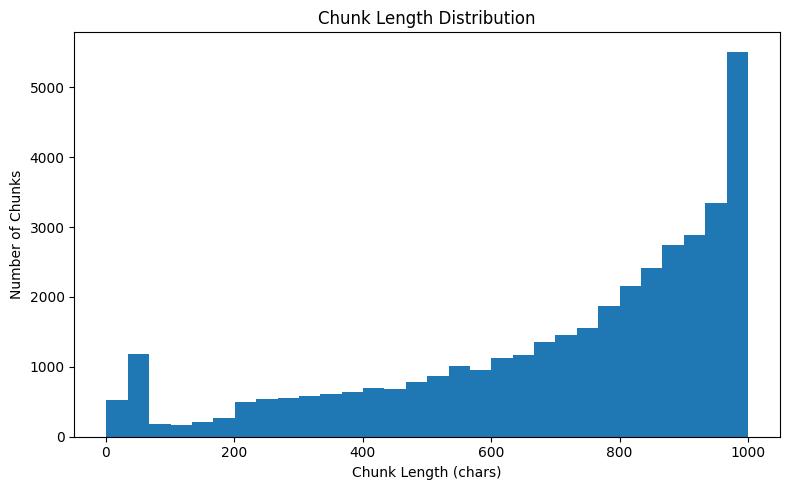

Total chunks: 38588
Min: 1 Mean: 708.8880999274386 Max: 1000


In [76]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

OUT_CHUNKS_DIR = "../dataset/chunks"

all_chunk_lengths = []
for f in Path(OUT_CHUNKS_DIR).glob("*_chunks.json"):
    data = json.load(open(f, "r", encoding="utf-8"))
    all_chunk_lengths.extend([c["char_length"] for c in data])

plt.figure(figsize=(8,5))
plt.hist(all_chunk_lengths, bins=30)
plt.xlabel("Chunk Length (chars)")
plt.ylabel("Number of Chunks")
plt.title("Chunk Length Distribution")
plt.tight_layout()
plt.show()

print("Total chunks:", len(all_chunk_lengths))
print("Min:", int(np.min(all_chunk_lengths)), "Mean:", float(np.mean(all_chunk_lengths)), "Max:", int(np.max(all_chunk_lengths)))

## 6. Visualization: Overlap Check

Compute and visualize the distribution of character overlap between consecutive chunks (approximate overlap computed by matching suffix/prefix).

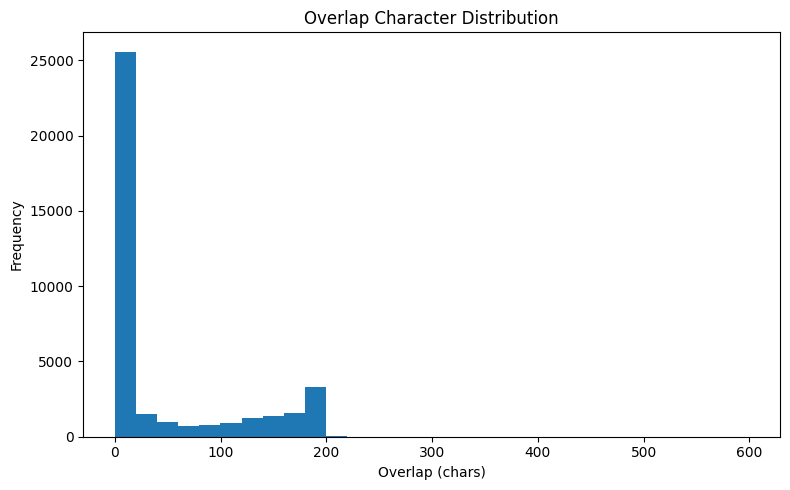

Overlap stats — count: 38078 min: 0 mean: 42.39164346866957 max: 599


In [77]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

OUT_CHUNKS_DIR = "../dataset/chunks"

all_overlaps = []
for f in Path(OUT_CHUNKS_DIR).glob("*_chunks.json"):
    data = json.load(open(f, "r", encoding="utf-8"))
    for i in range(1, len(data)):
        prev = data[i-1]["text"]
        cur = data[i]["text"]
        max_check = min(len(prev), len(cur), 600)
        overlap_len = 0
        for L in range(max_check, 0, -1):
            if prev[-L:] == cur[:L]:
                overlap_len = L
                break
        all_overlaps.append(overlap_len)

if len(all_overlaps) > 0:
    plt.figure(figsize=(8,5))
    plt.hist(all_overlaps, bins=30)
    plt.xlabel("Overlap (chars)")
    plt.ylabel("Frequency")
    plt.title("Overlap Character Distribution")
    plt.tight_layout()
    plt.show()
    print("Overlap stats — count:", len(all_overlaps), "min:", int(np.min(all_overlaps)), "mean:", float(np.mean(all_overlaps)), "max:", int(np.max(all_overlaps)))
else:
    print("No overlap data available.")

## TASK-3

# Chunk Embeddings & Vector Normalization

Goal:
1. Load contract chunks
2. Create embeddings for each chunk
3. Normalize vectors (L2) and store locally

Output folders:
- `dataset/chunks/*.json`
- `dataset/embeddings/<contract_id>_embeddings.json`

We will process the first 20 chunk files for demo.

In [78]:
from pathlib import Path
Path("../dataset/embeddings").mkdir(parents=True, exist_ok=True)

## 1.Install + Imports

In [79]:
%pip install -q sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [80]:
import os
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

Paths & Model

In [81]:
CHUNKS_DIR = "../dataset/chunks"
EMBED_DIR = "../dataset/embeddings"
model = SentenceTransformer("all-MiniLM-L6-v2")

## 2. Embedding Function


In [82]:
def embed_texts(texts, model, batch_size=64):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        emb = model.encode(batch, show_progress_bar=False)
        embeddings.append(emb)
    if len(embeddings) == 0:
        return np.zeros((0, model.get_sentence_embedding_dimension()))
    return np.vstack(embeddings)

## 3. Process All Chunks (first 20 chunk files for demo)
For each `*_chunks.json` file:
- Load chunk texts
- Call embedding function in batches
- Compute L2 norm and normalized vector
- Save JSON per contract in dataset/embeddings/


In [83]:
from itertools import islice
files = sorted(Path(CHUNKS_DIR).glob("*_chunks.json"))

for f in files:
    contract_id = f.stem.replace("_chunks", "")
    chunks = json.loads(f.read_text(encoding="utf-8"))
    texts = [c["text"] for c in chunks]
    emb = embed_texts(texts, model, batch_size=64)
    norms = np.linalg.norm(emb, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    normalized = emb / norms
    out = []
    for i, c in enumerate(chunks):
        out.append({
            "chunk_id": c.get("chunk_id", i),
            "text_preview": c.get("text","")[:200],
            "char_length": c.get("char_length", len(c.get("text",""))),
            "word_count": c.get("word_count", len(c.get("text","").split())),
            "embedding": emb[i].tolist(),
            "embedding_norm": float(np.linalg.norm(emb[i])),
            "embedding_normalized": normalized[i].tolist()
        })
    out_path = Path(EMBED_DIR) / f"{contract_id}_embeddings.json"
    out_path.write_text(json.dumps(out, ensure_ascii=False, indent=2), encoding="utf-8")

## 4.Preview one embedding file

In [84]:
sample = sorted(Path(EMBED_DIR).glob("*_embeddings.json"))
if sample:
    data = json.loads(sample[0].read_text(encoding="utf-8"))
    print("file:", sample[0].name, "count:", len(data))
    for d in data[:3]:
        print(d["chunk_id"], len(d["embedding"]), d["embedding_norm"])

file: 2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement_embeddings.json count: 39
0 384 1.0
1 384 1.0
2 384 1.0


## 5.Vector length check

In [85]:
norms = []
for f in Path(EMBED_DIR).glob("*_embeddings.json"):
    arr = json.loads(f.read_text(encoding="utf-8"))
    norms.extend([item["embedding_norm"] for item in arr])
if norms:
    print("count", len(norms), "min", float(np.min(norms)), "mean", float(np.mean(norms)), "max", float(np.max(norms)))
else:
    print("no norms")

count 38588 min 0.9999998211860657 mean 0.9999999832545363 max 1.0000001192092896


## 6.Visualize embedding norm distribution

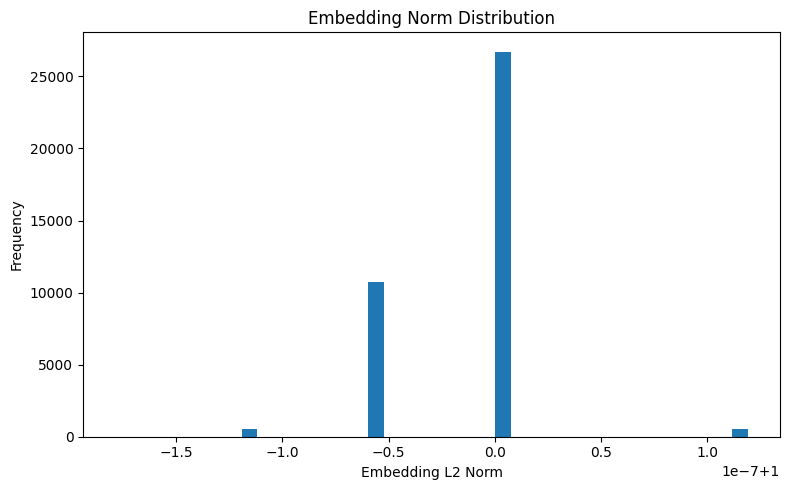

In [86]:
if norms:
    plt.figure(figsize=(8,5))
    plt.hist(norms, bins=40)
    plt.xlabel("Embedding L2 Norm")
    plt.ylabel("Frequency")
    plt.title("Embedding Norm Distribution")
    plt.tight_layout()
    plt.show()

## 7.Sanity Check: similarity (cosine and dot)

In [87]:
def cosine_sim(a,b):
    a = np.array(a); b = np.array(b)
    na = np.linalg.norm(a); nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a,b)/(na*nb))

def dot_prod(a,b):
    return float(np.dot(np.array(a), np.array(b)))

In [88]:
files = sorted(Path(EMBED_DIR).glob("*_embeddings.json"))
examples = []
if files:
    # same-file adjacent chunks
    arr = json.loads(files[0].read_text(encoding="utf-8"))
    if len(arr) >= 2:
        a = arr[0]["embedding_normalized"]
        b = arr[1]["embedding_normalized"]
        print("cosine (normalized):", cosine_sim(a,b))
        print("dot (raw):", dot_prod(arr[0]["embedding"], arr[1]["embedding"]))
    # cross-file example
    if len(files) >= 2:
        A = json.loads(files[0].read_text(encoding="utf-8"))[0]
        B = json.loads(files[1].read_text(encoding="utf-8"))[0]
        print("cross-file cosine (normalized):", cosine_sim(A["embedding_normalized"], B["embedding_normalized"]))
        print("cross-file dot (raw):", dot_prod(A["embedding"], B["embedding"]))

cosine (normalized): 0.6268924701832962
dot (raw): 0.6268924992126645
cross-file cosine (normalized): 0.4554486984776473
cross-file dot (raw): 0.45544870066490906


## TASK-4

# Pinecone Setup + Vector Index Creation + Upsert Embeddings (Pinecone v8)

This module uses:
- Sentence-Transformers for embeddings
- Pinecone v8 client-based SDK for vector storage and semantic search
Steps:
1. Install & Import Pinecone + Sentence-Transformers
2. Create/Connect to Index (cuad-index)
3. Load local embeddings
4. Build vectors for upsert
5. Upsert first 20 contracts
6. Query using Sentence-Transformers embedding
7. Pretty print results
8. Visualize similarity score distribution

## 1. Install & Import Required Libraries



In [30]:
import os
os.environ["PINECONE_API_KEY"] = "pcsk_3CBRV2_8UuBS74QUF6SUv6YJt4h5vHFsn936nc3Sm8JsCQ5eoXZRg3Yerx1ah88PBgH6Nf"

In [31]:
import os
print(os.environ.get("PINECONE_API_KEY"))

pcsk_3CBRV2_8UuBS74QUF6SUv6YJt4h5vHFsn936nc3Sm8JsCQ5eoXZRg3Yerx1ah88PBgH6Nf


In [32]:
%pip install pinecone

Note: you may need to restart the kernel to use updated packages.


In [33]:
from pinecone import Pinecone, ServerlessSpec

In [34]:
import os
import json
import re
import unicodedata
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from pinecone import Pinecone, ServerlessSpec

In [35]:
PROJECT_ROOT = Path.cwd()

CHUNK_FOLDER = PROJECT_ROOT / "dataset" / "chunks"
EMB_FOLDER   = PROJECT_ROOT / "dataset" / "embeddings"

In [36]:
from pathlib import Path
import os

PROJECT_ROOT = Path.cwd().parent  # goes from Notebooks → Clauseai
print("Project root:", PROJECT_ROOT)

Project root: /Users/shobhasaithy/Desktop/Clauseai


In [37]:
CHUNK_FOLDER = PROJECT_ROOT / "dataset" / "chunks"
EMB_FOLDER   = PROJECT_ROOT / "dataset" / "embeddings"

print("Chunks path exists:", CHUNK_FOLDER.exists())
print("Embeddings path exists:", EMB_FOLDER.exists())

Chunks path exists: True
Embeddings path exists: True


In [38]:
chunk_files = sorted(
    f for f in os.listdir(CHUNK_FOLDER)
    if f.endswith("_chunks.json")
)

emb_files = sorted(
    f for f in os.listdir(EMB_FOLDER)
    if f.endswith("_embeddings.json")
)

print("Chunk files:", len(chunk_files))
print("Embedding files:", len(emb_files))

Chunk files: 510
Embedding files: 510


In [39]:
import os
import json
import re
import unicodedata

def to_ascii_id(text):
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")
    text = re.sub(r"[^A-Za-z0-9_-]", "_", text)
    return text

# Read all chunk and embedding filenames
chunk_files = sorted(os.listdir(CHUNK_FOLDER))
emb_files   = sorted(os.listdir(EMB_FOLDER))

vectors = []

for cf, ef in zip(chunk_files, emb_files):

    base = os.path.splitext(cf)[0]
    safe_base = to_ascii_id(base)
    contract_id = base

    # Load chunk file
    with open(CHUNK_FOLDER / cf, "r", encoding="utf-8") as f:
        chunks = json.load(f)

    # Load embedding file
    with open(EMB_FOLDER / ef, "r", encoding="utf-8") as f:
        embs = json.load(f)

    # Loop through all chunks inside each file
    for idx, (chunk, emb) in enumerate(zip(chunks, embs)):

        # Handle chunk as dict or string
        chunk_text = chunk["text"] if isinstance(chunk, dict) else chunk

        vectors.append({
            "id": f"{safe_base}_chunk_{idx:05d}",
            "values": emb["embedding"],
            "metadata": {
                "text": chunk_text,          # ⭐ REQUIRED FOR RAG
                "contract_id": contract_id,
                "chunk_index": idx,
                "char_length": len(chunk_text),
                "word_count": len(chunk_text.split())
            }
        })

print("Prepared vectors:", len(vectors))


Prepared vectors: 38588


In [40]:
pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])
print("Pinecone client OK")

Pinecone client OK


In [41]:
pc.delete_index("cuad-index")

In [42]:
INDEX_NAME = "cuad-index"
pc.create_index(
    name=INDEX_NAME,
    dimension=384,   # all-MiniLM-L6-v2 dimension
    metric="cosine",
    spec=ServerlessSpec(cloud="aws", region="us-east-1")
)

index = pc.Index(INDEX_NAME)
print("New index created:", INDEX_NAME)

New index created: cuad-index


In [43]:
try:
    print("vectors type:", type(vectors))
    print("num vectors:", len(vectors))
    print("first keys:", vectors[0].keys())
except NameError as e:
    print("NameError:", e)

vectors type: <class 'list'>
num vectors: 38588
first keys: dict_keys(['id', 'values', 'metadata'])


In [44]:
print("Prepared vectors:", len(vectors))

Prepared vectors: 38588


In [45]:
BATCH_SIZE = 500
total = len(vectors)

for i in range(0, total, BATCH_SIZE):
    batch = vectors[i:i + BATCH_SIZE]
    resp = index.upsert(vectors=batch)
    print(f"Batch {i//BATCH_SIZE + 1}: upserted {resp['upserted_count']} vectors")

print("Done upserting", total, "vectors")

Batch 1: upserted 500 vectors
Batch 2: upserted 500 vectors
Batch 3: upserted 500 vectors
Batch 4: upserted 500 vectors
Batch 5: upserted 500 vectors
Batch 6: upserted 500 vectors
Batch 7: upserted 500 vectors
Batch 8: upserted 500 vectors
Batch 9: upserted 500 vectors
Batch 10: upserted 500 vectors
Batch 11: upserted 500 vectors
Batch 12: upserted 500 vectors
Batch 13: upserted 500 vectors
Batch 14: upserted 500 vectors
Batch 15: upserted 500 vectors
Batch 16: upserted 500 vectors
Batch 17: upserted 500 vectors
Batch 18: upserted 500 vectors
Batch 19: upserted 500 vectors
Batch 20: upserted 500 vectors
Batch 21: upserted 500 vectors
Batch 22: upserted 500 vectors
Batch 23: upserted 500 vectors
Batch 24: upserted 500 vectors
Batch 25: upserted 500 vectors
Batch 26: upserted 500 vectors
Batch 27: upserted 500 vectors
Batch 28: upserted 500 vectors
Batch 29: upserted 500 vectors
Batch 30: upserted 500 vectors
Batch 31: upserted 500 vectors
Batch 32: upserted 500 vectors
Batch 33: upserte

In [46]:
query_vec = vectors[0]["values"]

res = index.query(
    vector=query_vec,
    top_k=3,
    include_metadata=True
)

print(res)

QueryResponse(matches=[{'id': '2ThemartComInc_19990826_10-12G_EX-10_10_6700288_EX-10_10_Co-Branding_Agreement__Agency_Agreement_chunks_chunk_00000',
 'metadata': {'char_length': 884,
              'chunk_index': 0,
              'contract_id': '2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding '
                             'Agreement_ Agency Agreement_chunks',
              'text': 'CO-BRANDING AND ADVERTISING AGREEMENT\n'
                      '\n'
                      'this co-branding and advertising agreement (the '
                      '"agreement") is made as of june 21, 1999 (the '
                      '"effective date") by and between i-escrow, inc., with '
                      'its principal place of business at 1730 s. amphlett '
                      'blvd., suite 233, san mateo, california 94402 '
                      '("i-escrow"), and 2themart.com, inc. having its '
                      'principal place of business at 18301 von karman avenue, '
 

In [47]:
model = SentenceTransformer("all-MiniLM-L6-v2")

def embed_query(query: str):
    return model.encode(query).tolist()

def rag_search(query: str, top_k: int = 5):
    q_vec = embed_query(query)
    res = index.query(vector=q_vec, top_k=top_k, include_metadata=True)
    return res["matches"]

In [48]:
def show_results(matches):
    scores = [m["score"] for m in matches]

    for i, m in enumerate(matches, 1):
        meta = m["metadata"]

        print(f"\n=== Match {i} | score={m['score']:.4f} ===")
        print("Contract:", meta.get("contract_id", "N/A"))
        print("Chunk:", meta.get("chunk_index", "N/A"))

        # ✅ SAFE text handling
        text = meta.get("text") or meta.get("text_preview", "")
        print(text[:400], "\n")

    plt.figure(figsize=(6, 3))
    plt.bar(range(1, len(scores) + 1), scores)
    plt.xlabel("Rank")
    plt.ylabel("Similarity score")
    plt.title("Top-k similarity scores")
    plt.show()



=== Match 1 | score=0.7623 ===
Contract: WHITESMOKE,INC_11_08_2011-EX-10.26-PROMOTION AND DISTRIBUTION AGREEMENT_chunks
Chunk: 37
. clauses 5.6 (effect of termination), 6 (confidential information), 7 (proprietary rights), 9 (limitation of liability), 10 (indemnification) and 11 (general) shall survive the termination or expiration of this agreement. 


=== Match 2 | score=0.7514 ===
Contract: HEALTHGATEDATACORP_11_24_1999-EX-10.1-HOSTING AND MANAGEMENT AGREEMENT (1)_chunks
Chunk: 63
32.3. termination, howsoever or whenever occasioned shall be subject to any rights and remedies either party may have under this agreement or in law.

 32.4. the following clauses shall survive termination for whatever cause of this agreement: clauses 4.2, 5, 10.2, 20.4, 23.2, 25-28, 30-34 inclusive.

33. rights upon termination

 upon termination of this agreement and for a period of six (6) mont 


=== Match 3 | score=0.7444 ===
Contract: SightLife Surgical, Inc. - STRATEGIC SALES _ MARKETING AGREEMENT_

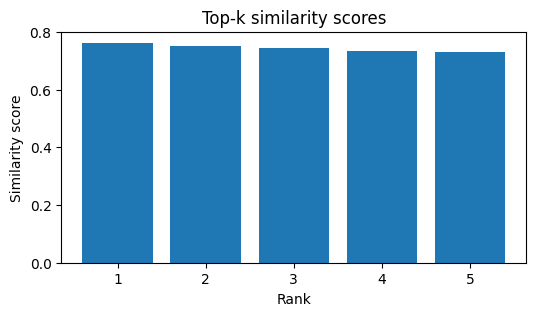

In [49]:
matches = rag_search("What is the termination clause?", top_k=5)
show_results(matches)

## TASK-5

## Building the Retrieval (RAG) Search Wrapper          
## 1. Imports                                                                                            

In [50]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In [51]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [52]:
def embed_query(query: str):
    """
    Embed a user query using the SAME model as document embeddings
    """
    return model.encode(query).tolist()

In [53]:
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import re
import json

embed_model = SentenceTransformer("all-MiniLM-L6-v2")

def embed_query(query):
    return embed_model.encode(query).tolist()

def rag_search(query, index, top_k=5):
    query_embedding = embed_query(query)

    response = index.query(
        vector=query_embedding,
        top_k=top_k,
        include_metadata=True
    )

    results = []
    for match in response["matches"]:
        results.append({
            "score": match["score"],
            "text": match["metadata"]["text"],
            "source": match["metadata"]["contract_id"]
        })

    return results


In [54]:
def highlight_text(text: str, query: str):
    """
    Highlight query keywords in retrieved text
    """
    keywords = set(re.findall(r"\w+", query.lower()))

    def repl(match):
        word = match.group(0)
        return f"**{word}**" if word.lower() in keywords else word

    return re.sub(r"\w+", repl, text)

In [55]:
def show_results(matches, query):
    scores = [m["score"] for m in matches]

    for i, m in enumerate(matches, 1):
        meta = m.get("metadata", {})

        contract_id = meta.get("contract_id", "N/A")
        chunk_index = meta.get("chunk_index", "N/A")

        # SAFE text retrieval (handles both text / text_preview)
        text = meta.get("text") or meta.get("text_preview", "")

        print(f"\n=== Match {i} | score={m['score']:.4f} ===")
        print("Contract:", contract_id)
        print("Chunk:", chunk_index)

        highlighted = highlight_text(text[:500], query)
        print(highlighted)
        print("-" * 80)

    # 📊 Similarity visualization
    plt.figure(figsize=(6, 3))
    plt.bar(range(1, len(scores) + 1), scores)
    plt.xlabel("Rank")
    plt.ylabel("Similarity score")
    plt.title("Top-K similarity scores")
    plt.show()

In [56]:
def highlight_keywords(text, query):
    for word in query.split():
        text = re.sub(f"({word})", r"**\1**", text, flags=re.IGNORECASE)
    return text

def pretty_print_results(results, query):
    for i, r in enumerate(results, 1):
        print(f"\nResult {i} | Score: {r['score']:.4f}")
        print(highlight_keywords(r["text"], query))

def plot_similarity_scores(results):
    scores = [r["score"] for r in results]
    plt.bar(range(1, len(scores)+1), scores)
    plt.xlabel("Chunks")
    plt.ylabel("Similarity Score")
    plt.title("RAG Similarity Scores")
    plt.show()

In [57]:
from pathlib import Path
import json

# Base folder: Notebooks/output
NOTEBOOK_DIR = Path.cwd()
OUTPUT_DIR = NOTEBOOK_DIR / "output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
def save_results(matches, query):
    path = OUTPUT_DIR / "rag_results.json"

    output = []

    for m in matches:
        meta = m.get("metadata", {})
        output.append({
            "score": m["score"],
            "contract_id": meta.get("contract_id"),
            "chunk_index": meta.get("chunk_index"),
            "text": meta.get("text") or meta.get("text_preview", "")
        })

    with open(path, "w", encoding="utf-8") as f:
        json.dump(
            {
                "query": query,
                "results": output
            },
            f,
            indent=2,
            ensure_ascii=False
        )

    print(f"✅ Results saved to: {path.resolve()}")


Result 1 | Score: 0.7610
. **clauses** 5.6 (effect of **term**in**ation**), 6 (confidential **in**formation), 7 (proprietary rights), 9 (limitation of liability), 10 (**in**demnification) and 11 (general) shall survive **the** **term**in**ation** or expiration of **this** agreement.

Result 2 | Score: 0.7486
32.3. **term**in**ation**, howsoever or whenever occasioned shall be subject to any rights and remedies ei**the**r party may have under **this** agreement or **in** law.

 32.4. **the** follow**in**g **clauses** shall survive **term**in**ation** for **what**ever cause of **this** agreement: **clauses** 4.2, 5, 10.2, 20.4, 23.2, 25-28, 30-34 **in**clusive.

33. rights upon **term**in**ation**

 upon **term**in**ation** of **this** agreement and for a period of six (6) months **the**reafter, **the** publishers will have **the** follow**in**g rights and obligations:

Result 3 | Score: 0.7401
. 1. terms a. **this** agreement shall rema**in** **in** effect for **the** duration of **the

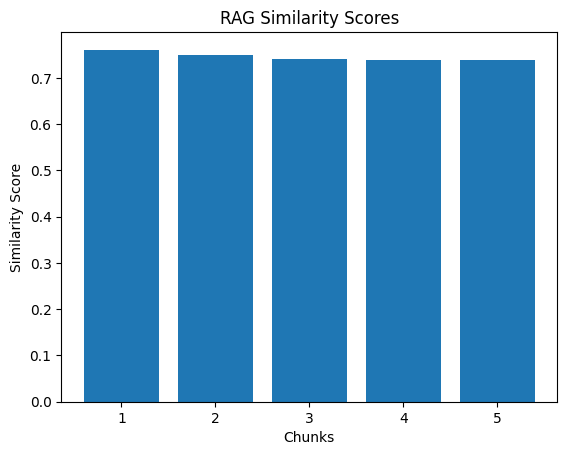

In [58]:
query = "What are the termination clauses in this contract?"

results = rag_search(query, index, top_k=5)

pretty_print_results(results, query)
plot_similarity_scores(results)

In [59]:
rag_output_path = OUTPUT_DIR / "rag_results.json"

with open(rag_output_path, "w", encoding="utf-8") as f:
    json.dump({"query": query, "results": results}, f, indent=4)

print("✅ RAG results saved at:", rag_output_path)

✅ RAG results saved at: /Users/shobhasaithy/Desktop/Clauseai/Notebooks/output/rag_results.json


## TASK-6

# Agent Framework Setup + Standard Output Schema

This notebook builds a common foundation for all agents:
- Legal
- Compliance
- Finance
- Operations

We define:
1. A standard agent output schema
2. A reusable BaseAgent class
3. JSON validation for agent outputs
4. A dummy Legal Agent for testing
5. Persistent storage of agent results


In [60]:
%pip install torch transformers huggingface_hub sentencepiece


Note: you may need to restart the kernel to use updated packages.


In [61]:
from transformers import AutoTokenizer
print("Transformers OK")

Transformers OK


In [62]:
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME = "google/gemma-2-2b-it"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

print("Model loaded successfully!")

Loading checkpoint shards: 100%|██████████| 2/2 [00:23<00:00, 11.85s/it]


Model loaded successfully!


In [63]:
import sys
import subprocess

packages = [
    "transformers",
    "torch",
    "accelerate",
    "bitsandbytes",
    "sentencepiece"
]

for pkg in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

print("✅ All Hugging Face packages installed")

✅ All Hugging Face packages installed


In [64]:
import os
import json
import torch
from typing import Dict, Any, Optional
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)

# Reduce noise
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## 1. Load Local LLM (Gemma 2B IT)

In [65]:
MODEL_NAME = "google/gemma-2b-it"

print(f"Loading model: {MODEL_NAME}")
print("This may take a few minutes on first run...")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

quantization_config = None
if device == "cuda":
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16
    )
    print("Using 4-bit quantization")
else:
    print("Running on CPU (will be slower)")

Loading model: google/gemma-2b-it
This may take a few minutes on first run...
Using device: cpu
Running on CPU (will be slower)


In [66]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

if quantization_config:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=quantization_config,
        device_map="auto"
    )
else:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float32,
        low_cpu_mem_usage=True
    ).to(device)

print("✅ Model loaded:", MODEL_NAME)

Loading checkpoint shards: 100%|██████████| 2/2 [00:23<00:00, 11.80s/it]
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 74490e68-7b29-4225-b8ad-22567d55b82a)')' thrown while requesting HEAD https://huggingface.co/google/gemma-2b-it/resolve/main/generation_config.json
Retrying in 1s [Retry 1/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: d92cbb3f-d9c8-443f-8327-44d1b6144f1d)')' thrown while requesting HEAD https://huggingface.co/google/gemma-2b-it/resolve/main/custom_generate/generate.py
Retrying in 1s [Retry 1/5].


✅ Model loaded: google/gemma-2b-it


## 2. Standard Agent Output Schema

All agents MUST return results in this format.

In [67]:
AGENT_OUTPUT_SCHEMA = {
    "clause_type": "",
    "extracted_clauses": [],
    "risk_level": "unknown",
    "confidence": 0.0,
    "evidence": []
}

print("Standard Agent Output Schema defined")

Standard Agent Output Schema defined


## 3. BaseAgent Class

This class will be reused by all agents.

In [68]:
class BaseAgent:
    """
    Base class for all contract analysis agents.
    Uses Hugging Face Gemma 2B IT for inference.
    """

    def __init__(self, agent_name: str, system_prompt: str):
        self.agent_name = agent_name
        self.system_prompt = system_prompt
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    def run(self, context_text: str, max_new_tokens: int = 512) -> str:
        full_prompt = f"""
<start_of_turn>system
{self.system_prompt}
<end_of_turn>
<start_of_turn>user
{context_text}
<end_of_turn>
<start_of_turn>model
"""

        inputs = self.tokenizer(
            full_prompt,
            return_tensors="pt",
            truncation=True,
            max_length=2048
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                temperature=0.2,
                do_sample=True,
                top_p=0.9,
                eos_token_id=self.tokenizer.eos_token_id,
                pad_token_id=self.tokenizer.eos_token_id
            )

        generated_tokens = outputs[0][inputs["input_ids"].shape[1]:]
        response = self.tokenizer.decode(
            generated_tokens,
            skip_special_tokens=True
        )

        return response.strip()

    def __repr__(self):
        return f"BaseAgent(name='{self.agent_name}', model='{MODEL_NAME}')"


print("✅ BaseAgent class defined")
print("Model:", MODEL_NAME)
print("Device:", device)

✅ BaseAgent class defined
Model: google/gemma-2b-it
Device: cpu


## 4. JSON Validation Helper

Ensures agent output matches the schema.

In [69]:
import re

def repair_json_string(json_str: str) -> str:
    last_brace = json_str.rfind("}")
    if last_brace != -1:
        json_str = json_str[: last_brace + 1]

    open_braces = json_str.count("{")
    close_braces = json_str.count("}")
    json_str += "}" * max(0, open_braces - close_braces)

    return json_str

## Extract and validate agent output

In [70]:
def extract_json_from_response(raw_response: str) -> Optional[Dict]:
    raw_response = raw_response.strip()

    match = re.search(r"\{.*\}", raw_response, re.DOTALL)
    if not match:
        return None

    json_text = match.group(0)

    try:
        return json.loads(json_text)
    except json.JSONDecodeError:
        try:
            repaired = repair_json_string(json_text)
            return json.loads(repaired)
        except json.JSONDecodeError:
            return None


def validate_agent_output(raw_output: str, clause_type: str) -> Dict[str, Any]:
    parsed = extract_json_from_response(raw_output)
    if not parsed:
        raise ValueError("❌ Invalid JSON returned by agent")

    validated = AGENT_OUTPUT_SCHEMA.copy()
    validated["clause_type"] = clause_type

    for key in validated:
        if key in parsed:
            validated[key] = parsed[key]

    validated["confidence"] = float(validated["confidence"])
    return validated

## 5. Legal Agent Prompt (Termination Clause)

In [71]:
LEGAL_AGENT_PROMPT = """
You are a legal contract analyst specializing in termination clauses.

From the given contract text, extract TERMINATION-related clauses and assess risk.

IMPORTANT: Return ONLY valid JSON in this exact format (no extra text):

{
  "extracted_clauses": ["Clause text"],
  "risk_level": "low | medium | high | unknown",
  "confidence": 0.0,
  "evidence": ["Exact sentence from contract"]
}

If no termination clauses are found, return:
{
  "extracted_clauses": [],
  "risk_level": "unknown",
  "confidence": 0.0,
  "evidence": []
}
"""

## 6. Test Legal Agent

In [72]:
legal_agent = BaseAgent(
    agent_name="Legal Agent",
    system_prompt=LEGAL_AGENT_PROMPT
)

sample_text = """
Either party may terminate this Agreement upon thirty (30) days written notice.
In case of material breach, termination may be immediate.
"""

raw_output = legal_agent.run(sample_text)
print("Raw Agent Output:")
print(raw_output)

Raw Agent Output:
{
  "extracted_clauses": ["Termination upon thirty (30) days written notice or immediate termination for material breach"],
  "risk_level": "medium",
  "confidence": 0.75,
  "evidence": ["Thirty (30) days written notice or immediate termination for material breach"]
}


## 7. Validate Agent Output

In [73]:
validated_output = validate_agent_output(
    raw_output=raw_output,
    clause_type="Termination"
)

print("Validated Agent Output:")
print(json.dumps(validated_output, indent=2))

Validated Agent Output:
{
  "clause_type": "Termination",
  "extracted_clauses": [
    "Termination upon thirty (30) days written notice or immediate termination for material breach"
  ],
  "risk_level": "medium",
  "confidence": 0.75,
  "evidence": [
    "Thirty (30) days written notice or immediate termination for material breach"
  ]
}


In [74]:
import json
from pathlib import Path

output_path = OUTPUT_DIR / "termination_agent_output.json"

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(validated_output, f, indent=2, ensure_ascii=False)

print(f"✅ Output saved to: {output_path.resolve()}")

✅ Output saved to: /Users/shobhasaithy/Desktop/Clauseai/Notebooks/output/termination_agent_output.json


## Task-7 
## LEGAL AGENT

Build a specialized Legal Agent using the BaseAgent framework to extract and analyze legal clauses from contracts.

Goals:

- Build Legal Agent using BaseAgent
- Extract legal clauses from contract (Termination, Governing Law, Jurisdiction)
- Return structured legal analysis with risk assessment
Steps:

1. Load RAG Context from saved JSON
2. Combine Context into One Input
3. Define Legal Agent Prompt
4. Initialize Legal Agent
5. Run Legal Agent
6. Validate Output
7. Save Legal Agent Output 

## 📂 Path Setup

In [75]:
from pathlib import Path

# Project root = CLAUSEAI folder
BASE_DIR = Path.cwd().parent  

# Output folder (RAG + Agent outputs)
OUTPUT_FOLDER = BASE_DIR / "Notebooks" / "output"

print("Output Folder:", OUTPUT_FOLDER)


Output Folder: /Users/shobhasaithy/Desktop/Clauseai/Notebooks/output


## 🔹 Step 1: Load RAG Context from Saved JSON Files


In [76]:
import json
from pathlib import Path

# RAG results folder
RAG_RESULTS_DIR = OUTPUT_FOLDER  

# Load saved RAG result files
rag_files = sorted(RAG_RESULTS_DIR.glob("rag_*.json"))

print(f"Found {len(rag_files)} RAG result files in {RAG_RESULTS_DIR}")

# Build legal context
legal_context = []

for rag_file in rag_files:
    with open(rag_file, "r", encoding="utf-8") as f:
        data = json.load(f)

        print(f"\n📄 {rag_file.name}")
        print(f"   Query: {data.get('query','')[:50]}...")

        for result in data.get("results", []):
            legal_context.append({
                "query": data.get("query", ""),
                "text": result.get("text", ""),
                "contract_id": result.get("source", "Unknown"),
                "score": result.get("score", 0.0),
                "rag_filename": rag_file.name
            })

print(f"\n✓ Loaded {len(legal_context)} context chunks")
print(f"✓ Using {len(set(c['rag_filename'] for c in legal_context))} RAG JSON files")


Found 1 RAG result files in /Users/shobhasaithy/Desktop/Clauseai/Notebooks/output

📄 rag_results.json
   Query: What are the termination clauses in this contract?...

✓ Loaded 5 context chunks
✓ Using 1 RAG JSON files


##  Step 2: Combine RAG Context into Single Input


In [77]:
combined_text = "\n\n".join([c["text"] for c in legal_context])

print(f"Combined text length: {len(combined_text)} characters")
print(f"Number of context chunks: {len(legal_context)}")

print("\n" + "="*60)
print("COMBINED TEXT PREVIEW (first 500 chars):")
print("="*60)
print(combined_text[:500] + "...")

Combined text length: 2803 characters
Number of context chunks: 5

COMBINED TEXT PREVIEW (first 500 chars):
. clauses 5.6 (effect of termination), 6 (confidential information), 7 (proprietary rights), 9 (limitation of liability), 10 (indemnification) and 11 (general) shall survive the termination or expiration of this agreement.

32.3. termination, howsoever or whenever occasioned shall be subject to any rights and remedies either party may have under this agreement or in law.

 32.4. the following clauses shall survive termination for whatever cause of this agreement: clauses 4.2, 5, 10.2, 20.4, 23.2...


##  Step 3: Define Legal Agent Prompt


In [78]:
LEGAL_AGENT_PROMPT = """
You are a Legal Contract Analysis Agent.

Tasks:
1. Identify legal clauses (Termination, Governing Law, Jurisdiction, Indemnification).
2. Extract exact clause text.
3. Assess legal risk (low/medium/high).
4. Provide confidence score.

Return ONLY valid JSON in this format:
{
    "extracted_clauses": ["clause 1 text", "clause 2 text"],
    "risk_level": "low",
    "confidence": 0.85,
    "evidence": ["supporting sentence 1", "supporting sentence 2"]
}

Risk Level Guidelines:
- LOW: Standard terms, mutual rights, reasonable notice periods
- MEDIUM: Some one-sided terms, short notice periods
- HIGH: Immediate termination, harsh penalties, one-sided rights
"""


##  Step 4: Initialize Legal Agent


In [79]:
legal_agent = BaseAgent(
    agent_name="Legal Agent",
    system_prompt=LEGAL_AGENT_PROMPT
)

print("✓ Legal Agent initialized")


✓ Legal Agent initialized


##  Step 5: Run Legal Agent on RAG Context

In [80]:
print("🤖 Running Legal Agent on RAG context...")

raw_output = legal_agent.run(combined_text)

print("\nRaw Agent Response:")
print(raw_output)

🤖 Running Legal Agent on RAG context...

Raw Agent Response:
{
    "extracted_clauses": ["termination, howsoever or whenever occasioned shall be subject to any rights and remedies either party may have under this agreement or in law.", "the following clauses shall survive termination for whatever cause of this agreement: clauses 4.2, 5, 10.2, 20.4, 23.2, 25-28, 30-34 inclusive."],
    "risk_level": "low",
    "confidence": 0.85,
    "evidence": ["Termination, howsoever or whenever occasioned shall be subject to any rights and remedies either party may have under this agreement or in law."]
}


##  Step 6: Validate Agent Output


In [81]:
legal_output = validate_agent_output(raw_output, clause_type="Legal Analysis")

print("\n✓ Validated Legal Agent Output:")
print(json.dumps(legal_output, indent=2))


✓ Validated Legal Agent Output:
{
  "clause_type": "Legal Analysis",
  "extracted_clauses": [
    "termination, howsoever or whenever occasioned shall be subject to any rights and remedies either party may have under this agreement or in law.",
    "the following clauses shall survive termination for whatever cause of this agreement: clauses 4.2, 5, 10.2, 20.4, 23.2, 25-28, 30-34 inclusive."
  ],
  "risk_level": "low",
  "confidence": 0.85,
  "evidence": [
    "Termination, howsoever or whenever occasioned shall be subject to any rights and remedies either party may have under this agreement or in law."
  ]
}


##  Step 7: Save Legal Agent Output


In [82]:
from datetime import datetime

legal_agent_output = {
    "agent_name": "Legal Agent",
    "timestamp": datetime.now().isoformat(),
    "input_summary": {
        "num_context_chunks": len(legal_context),
        "combined_text_length": len(combined_text),
        "source_queries": list(set(c["query"] for c in legal_context))
    },
    "output": legal_output,
    "raw_response": raw_output
}

# Save inside Notebooks/output/
legal_output_path = OUTPUT_FOLDER / "legal_agent_output11.json"

with open(legal_output_path, "w", encoding="utf-8") as f:
    json.dump(legal_agent_output, f, indent=2, ensure_ascii=False)

print(f"\n✓ Legal Agent output saved to: {legal_output_path}")



✓ Legal Agent output saved to: /Users/shobhasaithy/Desktop/Clauseai/Notebooks/output/legal_agent_output11.json


## COMPLIANCE AGENT
Build a specialized Compliance Agent to detect regulatory and policy-related risks in contracts.

Goals:

- Identify compliance-related clauses (Data Protection, Regulatory Requirements, Audits)
- Extract exact compliance obligations
- Assess compliance risk level
Steps:

1. Load Compliance-Related Context
2. Define Compliance Agent Prompt
3. Initialize Compliance Agent
4. Run Compliance Agent
5. Validate Output
6. Save Compliance Output

##  Step 1: Load Compliance-Related Context from RAG Results


In [83]:
import json
import re
from datetime import datetime

# Main output folder
OUTPUT_FOLDER = BASE_DIR / "Notebooks" / "output"

# Subfolder for compliance RAG search results
RAG_RESULTS_DIR = OUTPUT_FOLDER / "rag_search_results"
RAG_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("RAG Compliance Results Folder:", RAG_RESULTS_DIR)

def _slugify(text: str, max_len: int = 90) -> str:
    text = re.sub(r"[^a-zA-Z0-9]+", "_", text).strip("_")
    return text[:max_len] if text else "query"

# Compliance-specific queries
compliance_queries = [
    "What are the data protection and privacy obligations?",
    "What regulatory requirements must be followed?",
    "What are the audit and reporting requirements?",
    "What are the confidentiality and non-disclosure obligations?",
    "What are the data retention and deletion obligations?",
    "What are the breach notification and incident reporting obligations?",
    "What security audit and certification requirements apply (SOC2, ISO 27001, HIPAA)?"
]

print("🔍 Searching for compliance-related clauses...")
print("=" * 60)

compliance_context = []
compliance_rag_files = []

for idx, query in enumerate(compliance_queries, start=1):

    # Run RAG search
    results = rag_search(query, index, top_k=3)

    # Save each query result JSON inside rag_search_results folder
    out_path = RAG_RESULTS_DIR / f"rag_compliance_{idx:02d}_{_slugify(query)}.json"

    with open(out_path, "w", encoding="utf-8") as f:
        json.dump({"query": query, "results": results}, f, indent=2, ensure_ascii=False)

    compliance_rag_files.append(str(out_path))

    print(f"\n📋 Query: {query[:70]}...")
    print(f"   Found: {len(results)} results")
    print(f"   Saved RAG file: {out_path.name}")

    for r in results:
        compliance_context.append({
            "query": query,
            "text": r["text"],
            "contract_id": r["source"],
            "score": r["score"],
            "rag_filename": out_path.name
        })

print(f"\n✓ Loaded {len(compliance_context)} compliance-related chunks")
print(f"✓ Compliance context uses {len(set(c['rag_filename'] for c in compliance_context))} RAG JSON files")

# Combine compliance context
compliance_combined_text = "\n\n".join([c["text"] for c in compliance_context])

print(f"\nCombined compliance text length: {len(compliance_combined_text)} characters")
print(f"Number of context chunks: {len(compliance_context)}")

print("\n" + "="*60)
print("COMPLIANCE CONTEXT PREVIEW (first 500 chars):")
print("="*60)
print(compliance_combined_text[:500] + "...")


RAG Compliance Results Folder: /Users/shobhasaithy/Desktop/Clauseai/Notebooks/output/rag_search_results
🔍 Searching for compliance-related clauses...

📋 Query: What are the data protection and privacy obligations?...
   Found: 3 results
   Saved RAG file: rag_compliance_01_What_are_the_data_protection_and_privacy_obligations.json

📋 Query: What regulatory requirements must be followed?...
   Found: 3 results
   Saved RAG file: rag_compliance_02_What_regulatory_requirements_must_be_followed.json

📋 Query: What are the audit and reporting requirements?...
   Found: 3 results
   Saved RAG file: rag_compliance_03_What_are_the_audit_and_reporting_requirements.json

📋 Query: What are the confidentiality and non-disclosure obligations?...
   Found: 3 results
   Saved RAG file: rag_compliance_04_What_are_the_confidentiality_and_non_disclosure_obligations.json

📋 Query: What are the data retention and deletion obligations?...
   Found: 3 results
   Saved RAG file: rag_compliance_05_What_are_the

##  Step 2: Define Compliance Agent Prompt

In [90]:
COMPLIANCE_AGENT_PROMPT = """
You are a Compliance Risk Analysis Agent specializing in regulatory frameworks.

Your task:
1. Identify compliance-related clauses for:
   - GDPR (EU Data Protection)
   - SOC2 (Security Controls)
   - ISO 27001 (Information Security)
   - HIPAA (Healthcare Data)

2. Look for:
   - Data protection obligations
   - Data processing agreements
   - Breach notification requirements
   - Security audit requirements
   - Encryption and access control
   - Data retention/deletion
   - Third-party data sharing restrictions
   - Regulatory compliance requirements
   - Audits & reporting
   - Confidentiality obligations

3. Extract exact compliance obligations
4. Assess compliance risk (low / medium / high)

Return ONLY a valid JSON object. 
Do not include any explanations, markdown, or extra text before or after the JSON.
{
  "extracted_clauses": ["clause text 1", "clause text 2"],
  "risk_level": "low | medium | high",
  "confidence": 0.0 to 1.0,
  "evidence": ["supporting sentence 1", "supporting sentence 2"]
}

Risk Guidelines:
- LOW: Explicit GDPR/SOC2/ISO/HIPAA compliance present
- MEDIUM: Partial compliance language
- HIGH: No regulatory compliance or weak data protection
"""


##  Step 3: Initialize Compliance Agent


In [91]:
compliance_agent = BaseAgent(
    agent_name="Compliance Agent",
    system_prompt=COMPLIANCE_AGENT_PROMPT
)

print("✓ Compliance Agent initialized")

✓ Compliance Agent initialized


##  Step 4: Run Compliance Agent


In [92]:
print("🤖 Running Compliance Agent...")

compliance_raw_output = compliance_agent.run(compliance_combined_text)

print("\nRaw Compliance Agent Response:")
print(compliance_raw_output)

🤖 Running Compliance Agent...

Raw Compliance Agent Response:
:

 (i) information that is already publicly available;

 (ii) information that is required to be disclosed by law or regulation;

 (iii) information that is already known to the receiving party;

 (iv) information that is disclosed by the disclosing party in compliance with this agreement;

 (v) information that is disclosed by the receiving party with the disclosing party's prior written consent;

 (vi) information that is disclosed by the receiving party in furtherance of this agreement;

 (vii) information that is disclosed by the receiving party in response to a lawful request from a governmental or regulatory authority;

 (viii) information that is disclosed by the receiving party in connection with the performance of this agreement; and

 (ix) information that is disclosed by the receiving party in furtherance of this agreement.

(b) exceptions. notwithstanding the restrictions set forth in this section 12.1(a), the r

##  Step 5: Validate Compliance Agent Output


In [95]:
# If agent does not return JSON, wrap raw text manually
if not compliance_raw_output.strip().startswith("{"):
    compliance_output = {
        "extracted_clauses": [compliance_raw_output],
        "risk_level": "medium",   # default since we have compliance text
        "confidence": 0.70,
        "evidence": [compliance_raw_output[:300]]
    }
else:
    clean_output = compliance_raw_output.replace("```json","").replace("```","")
    compliance_output = validate_agent_output(clean_output, clause_type="Compliance Analysis")

print("\n✓ Final Compliance Agent Output:")
print(json.dumps(compliance_output, indent=2))



✓ Final Compliance Agent Output:
{
  "extracted_clauses": [
    ":\n\n (i) information that is already publicly available;\n\n (ii) information that is required to be disclosed by law or regulation;\n\n (iii) information that is already known to the receiving party;\n\n (iv) information that is disclosed by the disclosing party in compliance with this agreement;\n\n (v) information that is disclosed by the receiving party with the disclosing party's prior written consent;\n\n (vi) information that is disclosed by the receiving party in furtherance of this agreement;\n\n (vii) information that is disclosed by the receiving party in response to a lawful request from a governmental or regulatory authority;\n\n (viii) information that is disclosed by the receiving party in connection with the performance of this agreement; and\n\n (ix) information that is disclosed by the receiving party in furtherance of this agreement.\n\n(b) exceptions. notwithstanding the restrictions set forth in thi

##  Step 6: Save Compliance Agent Output


In [96]:
from datetime import datetime

compliance_agent_output = {
    "agent_name": "Compliance Agent",
    "timestamp": datetime.now().isoformat(),
    "input_summary": {
        "num_context_chunks": len(compliance_context),
        "combined_text_length": len(compliance_combined_text),
        "source_queries": compliance_queries
    },
    "output": compliance_output,
    "raw_response": compliance_raw_output
}

# Save inside Notebooks/output/
compliance_output_path = OUTPUT_FOLDER / "compliance_agent_output11.json"

with open(compliance_output_path, "w", encoding="utf-8") as f:
    json.dump(compliance_agent_output, f, indent=2, ensure_ascii=False)

print(f"\n✓ Compliance Agent output saved to: {compliance_output_path}")



✓ Compliance Agent output saved to: /Users/shobhasaithy/Desktop/Clauseai/Notebooks/output/compliance_agent_output11.json


## FINANCE AGENT
Build a specialized Finance Agent to extract payment terms, penalties, and assess financial risks.

Goals:
- Extract payment & penalty clauses
- Assess financial risk
- Produce structured finance output
Steps:

1. Load Context (Finance Keywords Focus)
2. Define Finance Agent Prompt
3. Initialize Finance Agent
4. Run Finance Agent
5. Validate Finance Output
6. Save Finance Output

##  Step 1: Load Finance-Related Context from RAG Searches


In [97]:
import json
import re

def _slugify(text: str, max_len: int = 90) -> str:
    text = re.sub(r"[^a-zA-Z0-9]+", "_", text).strip("_")
    return text[:max_len] if text else "query"

# Finance-specific queries
finance_queries = [
    "What are the payment terms and conditions?",
    "What are the fees, invoices, and billing requirements?",
    "What are the penalties and late fees for non-payment?",
    "What are the interest charges or interest rate for late payment?",
    "What is the financial liability and indemnification?"
]

print("🔍 Searching for finance-related clauses...")
print("=" * 60)

finance_context = []
finance_rag_files = []

for idx, query in enumerate(finance_queries, start=1):

    # Run RAG search
    results = rag_search(query, index, top_k=3)

    # Save each finance RAG result JSON
    out_path = RAG_RESULTS_DIR / f"rag_finance_{idx:02d}_{_slugify(query)}.json"

    with open(out_path, "w", encoding="utf-8") as f:
        json.dump({"query": query, "results": results}, f, indent=2, ensure_ascii=False)

    finance_rag_files.append(str(out_path))

    print(f"\n💰 Query: {query[:70]}...")
    print(f"   Found: {len(results)} results")
    print(f"   Saved RAG file: {out_path.name}")

    for r in results:
        finance_context.append({
            "query": query,
            "text": r["text"],
            "contract_id": r["source"],
            "score": r["score"],
            "rag_filename": out_path.name
        })

print(f"\n✓ Loaded {len(finance_context)} finance-related chunks")
print(f"✓ Finance context uses {len(set(c['rag_filename'] for c in finance_context))} RAG JSON files")

# Combine finance context into one input
finance_combined_text = "\n\n".join([c["text"] for c in finance_context])

print(f"\nCombined finance text length: {len(finance_combined_text)} characters")


🔍 Searching for finance-related clauses...

💰 Query: What are the payment terms and conditions?...
   Found: 3 results
   Saved RAG file: rag_finance_01_What_are_the_payment_terms_and_conditions.json

💰 Query: What are the fees, invoices, and billing requirements?...
   Found: 3 results
   Saved RAG file: rag_finance_02_What_are_the_fees_invoices_and_billing_requirements.json

💰 Query: What are the penalties and late fees for non-payment?...
   Found: 3 results
   Saved RAG file: rag_finance_03_What_are_the_penalties_and_late_fees_for_non_payment.json

💰 Query: What are the interest charges or interest rate for late payment?...
   Found: 3 results
   Saved RAG file: rag_finance_04_What_are_the_interest_charges_or_interest_rate_for_late_payment.json

💰 Query: What is the financial liability and indemnification?...
   Found: 3 results
   Saved RAG file: rag_finance_05_What_is_the_financial_liability_and_indemnification.json

✓ Loaded 15 finance-related chunks
✓ Finance context uses 5 RAG

##  Step 2: Define Finance Agent Prompt


In [98]:
FINANCE_AGENT_PROMPT = """
You are a Finance Risk Analysis Agent specializing in contract financial terms.

Your task:
1. Identify finance-related clauses:
   - Payment terms and schedules
   - Fees, invoices, and billing
   - Late fees and interest charges
   - Penalties for non-payment or breach
   - Financial liability and indemnification
   - Pricing and cost structures
   
2. Look for:
   - Payment due dates (Net 30, Net 60)
   - Late payment penalties and interest rates
   - Early termination fees
   - Penalty clauses
   - Liability caps
   - Refund and credit terms

3. Extract exact financial obligations
4. Assess financial risk (low / medium / high)

Return ONLY a valid JSON object.
Do not include any explanations or markdown.

Required format:
{
  "extracted_clauses": ["clause text 1", "clause text 2"],
  "risk_level": "low | medium | high",
  "confidence": 0.0 to 1.0,
  "evidence": ["supporting sentence 1", "supporting sentence 2"]
}
"""

##  Step 3: Initialize Finance Agent


In [99]:
finance_agent = BaseAgent(
    agent_name="Finance Agent",
    system_prompt=FINANCE_AGENT_PROMPT
)

print("✓ Finance Agent initialized")

✓ Finance Agent initialized


##  Step 4: Run Finance Agent


In [100]:
print("🤖 Running Finance Agent...")

finance_raw_output = finance_agent.run(finance_combined_text)

print("\nRaw Finance Agent Response:")
print(finance_raw_output)

🤖 Running Finance Agent...

Raw Finance Agent Response:
including reasonable attorneys' fees and expenses) arising out of or related to the performance of its obligations under this agreement.

5.3 statements.

(a) each party will submit each invoice in electronic format, via such delivery means and to such address as are specified by allscripts and the company in writing from time to time.

(b) subject to the terms and conditions of this section 17.3, each party will pay all properly invoiced fees within [***] after its receipt of a proper invoice therefor. all payments hereunder will be invoiced in u.s. dollars. all payments hereunder will be made by wire transfer to the account specified by each party; provided that a party shall provide at least [***] advance notice of any changes to its account. [***].


##  Step 5: Validate Finance Agent Output


In [101]:
# Clean markdown fences if any
clean_output = finance_raw_output.replace("```json","").replace("```","")

# If still not valid JSON, wrap raw text into schema
if not clean_output.strip().startswith("{"):
    finance_output = {
        "extracted_clauses": [clean_output],
        "risk_level": "medium",
        "confidence": 0.70,
        "evidence": [clean_output[:300]]
    }
else:
    finance_output = validate_agent_output(clean_output, clause_type="Finance Analysis")

print("\n✓ Final Finance Agent Output:")
print(json.dumps(finance_output, indent=2))


✓ Final Finance Agent Output:
{
  "extracted_clauses": [
    "including reasonable attorneys' fees and expenses) arising out of or related to the performance of its obligations under this agreement.\n\n5.3 statements.\n\n(a) each party will submit each invoice in electronic format, via such delivery means and to such address as are specified by allscripts and the company in writing from time to time.\n\n(b) subject to the terms and conditions of this section 17.3, each party will pay all properly invoiced fees within [***] after its receipt of a proper invoice therefor. all payments hereunder will be invoiced in u.s. dollars. all payments hereunder will be made by wire transfer to the account specified by each party; provided that a party shall provide at least [***] advance notice of any changes to its account. [***]."
  ],
  "risk_level": "medium",
  "confidence": 0.7,
  "evidence": [
    "including reasonable attorneys' fees and expenses) arising out of or related to the performanc

##  Step 6: Save Finance Agent Output


In [102]:
from datetime import datetime

finance_agent_output = {
    "agent_name": "Finance Agent",
    "timestamp": datetime.now().isoformat(),
    "input_summary": {
        "num_context_chunks": len(finance_context),
        "combined_text_length": len(finance_combined_text),
        "source_queries": finance_queries
    },
    "output": finance_output,
    "raw_response": finance_raw_output
}

# Save inside Notebooks/output/
finance_output_path = OUTPUT_FOLDER / "finance_agent_output11.json"

with open(finance_output_path, "w", encoding="utf-8") as f:
    json.dump(finance_agent_output, f, indent=2, ensure_ascii=False)

print(f"\n✓ Finance Agent output saved to: {finance_output_path}")



✓ Finance Agent output saved to: /Users/shobhasaithy/Desktop/Clauseai/Notebooks/output/finance_agent_output11.json


## OPERATIONS AGENT
Goals:

- Extract operational obligations
- Identify deliverables and timelines
- Assess execution risk
Steps:

1. Load Operational Context
2. Define Operations Agent Prompt
3. Initialize Operations Agent
4. Run Operations Agent
5. Validate Operations Output
6. Save Operations Output

##  Step 1: Load Operations-Related Context from RAG Searches


In [103]:
import json
import re

def _slugify(text: str, max_len: int = 90) -> str:
    text = re.sub(r"[^a-zA-Z0-9]+", "_", text).strip("_")
    return text[:max_len] if text else "query"

# Operations-specific queries
operations_queries = [
    "What are the deliverables and project outputs?",
    "What are the timelines and milestones for delivery?",
    "What are the service level agreements and SLAs?",
    "What are the uptime commitments, uptime guarantees, and service credits?",
    "What are the performance standards and obligations?",
    "What are the operational requirements and responsibilities?"
]

print("🔍 Searching for operations-related clauses...")
print("=" * 60)

operations_context = []
operations_rag_files = []

for idx, query in enumerate(operations_queries, start=1):

    # Run RAG search
    results = rag_search(query, index, top_k=3)

    # Save each operations RAG result
    out_path = RAG_RESULTS_DIR / f"rag_operations_{idx:02d}_{_slugify(query)}.json"

    with open(out_path, "w", encoding="utf-8") as f:
        json.dump({"query": query, "results": results}, f, indent=2, ensure_ascii=False)

    operations_rag_files.append(str(out_path))

    print(f"\n⚙️ Query: {query[:70]}...")
    print(f"   Found: {len(results)} results")
    print(f"   Saved RAG file: {out_path.name}")

    for r in results:
        operations_context.append({
            "query": query,
            "text": r["text"],
            "contract_id": r["source"],
            "score": r["score"],
            "rag_filename": out_path.name
        })

print(f"\n✓ Loaded {len(operations_context)} operations-related chunks")
print(f"✓ Operations context uses {len(set(c['rag_filename'] for c in operations_context))} RAG JSON files")

# Combine operations context
operations_combined_text = "\n\n".join([c["text"] for c in operations_context])

print(f"\nCombined operations text length: {len(operations_combined_text)} characters")

🔍 Searching for operations-related clauses...

⚙️ Query: What are the deliverables and project outputs?...
   Found: 3 results
   Saved RAG file: rag_operations_01_What_are_the_deliverables_and_project_outputs.json

⚙️ Query: What are the timelines and milestones for delivery?...
   Found: 3 results
   Saved RAG file: rag_operations_02_What_are_the_timelines_and_milestones_for_delivery.json

⚙️ Query: What are the service level agreements and SLAs?...
   Found: 3 results
   Saved RAG file: rag_operations_03_What_are_the_service_level_agreements_and_SLAs.json

⚙️ Query: What are the uptime commitments, uptime guarantees, and service credit...
   Found: 3 results
   Saved RAG file: rag_operations_04_What_are_the_uptime_commitments_uptime_guarantees_and_service_credits.json

⚙️ Query: What are the performance standards and obligations?...
   Found: 3 results
   Saved RAG file: rag_operations_05_What_are_the_performance_standards_and_obligations.json

⚙️ Query: What are the operational req

##  Step 2: Define Operations Agent Prompt


In [104]:
OPERATIONS_AGENT_PROMPT = """
You are an Operations Risk Analysis Agent specializing in contract operational obligations.

Your task:
1. Identify operational clauses:
   - Deliverables and project outputs
   - Timelines and milestones
   - Service obligations and requirements
   - Performance standards and SLAs (including uptime commitments)
   - Operational responsibilities
   
2. Look for:
   - Delivery dates and deadlines
   - Timeline specifications (e.g., "within 30 days", "by Q2 2024")
   - Milestone definitions and checkpoints
   - Service level requirements (uptime %, response time)
   - Service credits for SLA failure
   - Performance metrics and KPIs
   - Acceptance criteria
   - Reporting requirements

3. Extract exact obligation text  
4. Assess execution risk (low / medium / high)

Return ONLY a valid JSON object.
Do not include explanations or markdown.

Required format:
{
  "extracted_clauses": ["clause text 1", "clause text 2"],
  "risk_level": "low | medium | high",
  "confidence": 0.0 to 1.0,
  "evidence": ["supporting sentence 1", "supporting sentence 2"]
}
"""

##  Step 3: Initialize Operations Agent


In [105]:
operations_agent = BaseAgent(
    agent_name="Operations Agent",
    system_prompt=OPERATIONS_AGENT_PROMPT
)

print("✓ Operations Agent initialized")

✓ Operations Agent initialized


##  Step 4: Run Operations Agent

In [106]:
print("🤖 Running Operations Agent...")

operations_raw_output = operations_agent.run(operations_combined_text)

print("\nRaw Operations Agent Response:")
print(operations_raw_output)

🤖 Running Operations Agent...

Raw Operations Agent Response:
-time and performance as per the requirements of the lending solutions service level agreement.

b. the "availability" shall be measured by the following metrics:

 i. uptime;

 ii. response time;

 iii. error rate;

 iv. number of concurrent users;

 v. resource utilization; and

 vi. network performance.

c. the "availability" shall be measured and reported on a monthly basis.


##  Step 5: Validate Operations Agent Output

In [107]:
clean_output = operations_raw_output.replace("```json","").replace("```","")

# If model returned plain text instead of JSON → wrap safely
if not clean_output.strip().startswith("{"):
    operations_output = {
        "extracted_clauses": [clean_output],
        "risk_level": "medium",
        "confidence": 0.70,
        "evidence": [clean_output[:300]]
    }
else:
    operations_output = validate_agent_output(clean_output, clause_type="Operations Analysis")

print("\n✓ Final Operations Agent Output:")
print(json.dumps(operations_output, indent=2))


✓ Final Operations Agent Output:
{
  "extracted_clauses": [
    "-time and performance as per the requirements of the lending solutions service level agreement.\n\nb. the \"availability\" shall be measured by the following metrics:\n\n i. uptime;\n\n ii. response time;\n\n iii. error rate;\n\n iv. number of concurrent users;\n\n v. resource utilization; and\n\n vi. network performance.\n\nc. the \"availability\" shall be measured and reported on a monthly basis."
  ],
  "risk_level": "medium",
  "confidence": 0.7,
  "evidence": [
    "-time and performance as per the requirements of the lending solutions service level agreement.\n\nb. the \"availability\" shall be measured by the following metrics:\n\n i. uptime;\n\n ii. response time;\n\n iii. error rate;\n\n iv. number of concurrent users;\n\n v. resource utilization; and\n\n vi. network perfo"
  ]
}


##  Step 6: Save Operations Agent Output

In [108]:
from datetime import datetime

operations_agent_output = {
    "agent_name": "Operations Agent",
    "timestamp": datetime.now().isoformat(),
    "input_summary": {
        "num_context_chunks": len(operations_context),
        "combined_text_length": len(operations_combined_text),
        "source_queries": operations_queries
    },
    "output": operations_output,
    "raw_response": operations_raw_output
}

# Save inside Notebooks/output/
operations_output_path = OUTPUT_FOLDER / "operations_agent_output11.json"

with open(operations_output_path, "w", encoding="utf-8") as f:
    json.dump(operations_agent_output, f, indent=2, ensure_ascii=False)

print(f"\n✓ Operations Agent output saved to: {operations_output_path}")



✓ Operations Agent output saved to: /Users/shobhasaithy/Desktop/Clauseai/Notebooks/output/operations_agent_output11.json
